In [306]:
import numpy
import bempp.api
from bempp.api.operators.boundary import sparse, laplace
from scipy.sparse.linalg import gmres

In [307]:
def rhs_fun(x, n, domain_index,result):
    global phi_static
    result[:] = phi_static

def energy_sphere(R, d_stern, vertices, elements, eps_s):
    R_diel = R - d_stern

    grid_diel = bempp.api.grid_from_element_data(R_diel*vertices, elements)
    grid_stern = bempp.api.grid_from_element_data((R_diel+d_stern)*vertices, elements)

    space_diel = bempp.api.function_space(grid_diel, "DP", 0)
    space_stern = bempp.api.function_space(grid_stern, "DP", 0)
    
    N_diel = grid_diel.leaf_view.entity_count(0)
    N_stern = grid_stern.leaf_view.entity_count(0)

    phis_grid_fun = bempp.api.GridFunction(space_diel, fun=rhs_fun)

    rhs = numpy.concatenate([eps_s*phis_grid_fun.coefficients, 
                      numpy.zeros(N_stern)])
    
    M11   = laplace.single_layer(space_diel, space_diel, space_diel)
    M12   = laplace.single_layer(space_stern, space_diel, space_diel)
    M21   = laplace.single_layer(space_diel, space_stern, space_stern)
    M22   = laplace.single_layer(space_stern, space_stern, space_stern)

    blocked = bempp.api.BlockedOperator(2, 2)
    blocked[0,0] = M11
    blocked[0,1] = M12
    blocked[1,0] = M21
    blocked[1,1] = M22
    op_discrete = blocked.strong_form()
    
    sigma, info = gmres(op_discrete, rhs, tol=1e-5, maxiter=500, restart = 1000)
    
    sigma_d = sigma[:N_diel]
    sigma_s = sigma[N_diel:]
    
    elements_d = list(grid_diel.leaf_view.entity_iterator(0))
    elements_s = list(grid_stern.leaf_view.entity_iterator(0))

    area_d = numpy.zeros(N_diel)
    area_s = numpy.zeros(N_stern)

    for i in range(N_diel):
        area_d[i] = elements_d[i].geometry.volume
    for i in range(N_stern):
        area_s[i] = elements_s[i].geometry.volume
        
    energy = 0.5*numpy.sum(area_d*sigma_d*phi_static)
    
    e_a = energy/(4*numpy.pi*(R_diel+d_stern)**2)
    
    #e_a = energy/(4*numpy.pi*(R_diel)**2)
    return energy, e_a

In [308]:
grid_base = bempp.api.shapes.sphere(h=0.1)

vertices = grid_base.leaf_view.vertices 
elements = grid_base.leaf_view.elements 

d_stern = 1.4
phi_static = 10. # kcal/mol/e
phi_static *= 4.184 # kJ/mol/e
eps_s = 1.

Radius = 10*numpy.array([0.15903614457831333, 
0.23614457831325308, 
0.35180722891566263, 
0.48032128514056227, 
0.6409638554216868, 
0.8016064257028112, 
0.9590361445783132, 
1.1293172690763051, 
1.3542168674698791, 
1.6112449799196784, 
1.8811244979919675])

In [309]:
energy_area = numpy.zeros(len(Radius))
energy      = numpy.zeros(len(Radius))

for i in range(len(energy)):
    energy[i], energy_area[i] = energy_sphere(Radius[i], d_stern, vertices, elements, eps_s)
    
energy_area *= 6.022/1e3 # kJ/(mol*ang**2) to mJ/m**2 (according to fig 2 in Chandler 2005)
energy *= 6.022/1e3 # kJ/mol to mJ/(m**2)*ang**2

In [310]:
from matplotlib import pyplot

E_area_chandler = numpy.array([12.995391705069125,
24.239631336405523,
33.64055299539171,
44.51612903225807,
51.1520737327189,
55.20737327188941,
57.78801843317973,
59.44700460829494,
61.65898617511521,
64.0552995391705,
64.60829493087559])

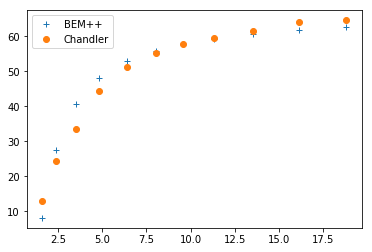

In [321]:
pyplot.plot(Radius, energy_area, marker='+', ls='', label='BEM++')
pyplot.plot(Radius, E_area_chandler, marker='o', ls='', label='Chandler')
pyplot.legend(loc='best')

In [312]:
pyplot.savefig('nonpolar_energy.pdf')

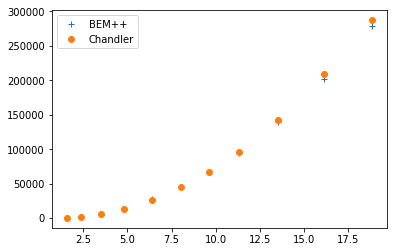

In [322]:
E_chandler = E_area_chandler*4*numpy.pi*Radius**2 # in mJ/(m**2)*angs**2
pyplot.plot(Radius, energy, marker='+', ls='', label='BEM++')
pyplot.plot(Radius, E_chandler, marker='o', ls='', label='Chandler')
pyplot.legend(loc='best')

In [314]:
# compute LJ energy
rho_w = 0.0336 # 1/angs3 number density of water at standard conditions
water_r = 1.7683 # angs
water_eps = 0.1520 # kcal/mol

ion_r = Radius - d_stern
ion_eps = 0.2#water_eps # LJ well depth

epsilon = numpy.sqrt(ion_eps*water_eps)

A = epsilon*(water_r + ion_r)**12
B = 2*epsilon*(water_r + ion_r)**6
surf_area = 4*numpy.pi*(ion_r+d_stern)**2

LJ_energy = -rho_w * (1/9.*A/(ion_r+1.4)**12 - 1/3.*B/(ion_r+1.4)**6) * surf_area
LJ_energy *= 4.184*1e6/(6.022e23*1e-20) # mJ/(m**2) * ang**2
LJ_energy_area = LJ_energy/surf_area # mJ/m**2

print LJ_energy
print LJ_energy_area

[   125.92223659    273.2795691     534.67952907    907.33933619
   1502.34289098   2242.86958291   3110.3898529    4207.01569837
   5907.69080621   8203.11096896  11017.25481594]
[ 3.96187608  3.89979109  3.43774908  3.12965316  2.90999419  2.77761326
  2.69113207  2.62501827  2.56348898  2.51446484  2.47758436]


In [315]:
energy_total = energy + LJ_energy
energy_area_total = energy_area + LJ_energy_area

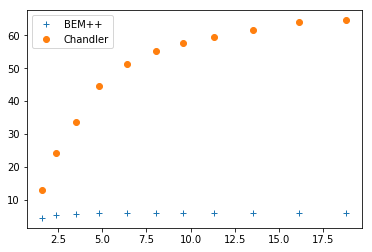

In [316]:
pyplot.plot(Radius, energy_area_total, marker='+', ls='', label='BEM++')
pyplot.plot(Radius, E_area_chandler, marker='o', ls='', label='Chandler')
pyplot.legend(loc='best')

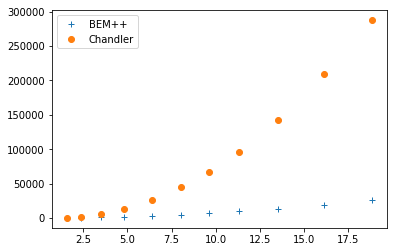

In [317]:
pyplot.plot(Radius, energy_total, marker='+', ls='', label='BEM++')
pyplot.plot(Radius, E_chandler, marker='o', ls='', label='Chandler')
pyplot.legend(loc='best')